# Due to one of the sweeping, found that electrolyte consumption just happen ridicously quick during RPT, even with very low V_EC, which I don't understand! So need to focous on RPT now. 

In [48]:
# magic lines that avoid re-start and load module
%load_ext autoreload
%autoreload 2
import pybamm as pb;import pandas as pd   ;import numpy as np;
import os;
import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
import scipy.optimize
import timeit
import random;import time, signal
fs=17;
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
## Global setting: change with PC or HPC
# Path_NiallDMA = "InputData/" # for HPC

# Path_NiallDMA = "D:/OneDrive - Imperial College London/SimDataSave/InputData/" # for Windows
Path_NiallDMA = os.path.expanduser("~/EnvPBGEM_Linux/SimSave/InputData/") # for Linux
# BasicPath=os.getcwd() # for HPC
# path for windows's pybamm in office PC 
# BasicPath = 'D:/OneDrive - Imperial College London/SimDataSave/P2_R9_Dim/Test'  
# for linux pybamm in office pc:
BasicPath =  os.path.expanduser("~/EnvPBGEM_Linux/SimSave/P2_R9_Dim")
import sys  
str_path_0 = os.path.abspath(os.path.join(pb.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip/Rio_Code/Fun_P2"))
sys.path.append(str_path_1) 
from Fun_P2 import * # directly do this for HPC

# Set Experiment : Exp-2
index_exp = 2 # index for experiment set, can now go for 2,3,5
Round_No = "debug_tot_Li"  # index to identify different rounds of running 
pool_no = 8
Runshort = True # True

if Runshort == False:
    if index_exp == 2:
        tot_cyc = 6192; cyc_age = 516;
    if index_exp == 3:
        tot_cyc = 6180; cyc_age = 515;
    if index_exp == 5:
        tot_cyc = 1170; cyc_age = 78;
else:
    if index_exp == 2:
        tot_cyc = 12; cyc_age = 4;
    if index_exp == 3:
        tot_cyc = 8; cyc_age = 2;
    if index_exp == 5:
        tot_cyc = 8; cyc_age = 2;

#########  Actively sweep parameters  ##############
Para_active = {
   "Ageing temperature":[25,], # 25, 40 
   "Total ageing cycles":[int(tot_cyc),], # 
   "Ageing cycles between RPT":[int(cyc_age),], # 
   "Update cycles for ageing": [int(cyc_age),],
   "Initial electrolyte excessive amount ratio":[ 1.01], # set to <1 for DryOut=Off
   # rate of dry-out:
   "EC partial molar volume [m3.mol-1]":[5.2e-5,] ,
   # interstitial-diffusion limited
   'Inner SEI lithium interstitial diffusivity [m2.s-1]':[1e-20,3e-20],    
   # LiP and coupling with SEI:
   "Dead lithium decay constant [s-1]":[ 1e-6,],            # default: 1e-6
   'Lithium plating kinetic rate constant [m.s-1]':[1E-10], # default: 1e-9
   # Crack model
   "Negative electrode LAM constant proportional term [s-1]":[ 1e-8], # default: 2.7778e-07
   "Positive electrode LAM constant proportional term [s-1]":[ 1e-16,], # default: 2.7778e-07
   "Negative electrode cracking rate":[ 1e-20,],   # default: function, ~3.9e-20 
}

In [50]:
# Inactively sweep parameters
Para_dict_Same = {
   #"Positive electrode cracking rate":[ 1e-22,],   # default: function, ~3.9e-20 
   "Cycles within RPT":[1,],
   "RPT temperature":[25,],
   "Mesh list":[[5,5,5,60,20],],   # Simon uses 30
   "Para_Set":[ "OKane2023",], # Li2023_Coupled
   "Model option":[
      {
         "contact resistance": "true",
         "open-circuit potential": "current sigmoid",
         "thermal": "lumped",
         "SEI": "interstitial-diffusion limited",
         "SEI on cracks": "true",
         "SEI film resistance": "distributed", 
         "SEI porosity change": "true",
         "particle mechanics": ("swelling and cracking", "swelling only"),
         "loss of active material": "stress-driven",
         "lithium plating": "partially reversible",
      },
      ],
   "Contact resistance [Ohm]": [0.0105,],   
   "Current solvent concentration in the reservoir [mol.m-3]":[4541.0,],
   "Current electrolyte concentration in the reservoir [mol.m-3]":[1000,],
   "Ratio of Li-ion concentration change in electrolyte consider solvent consumption":[1.0,],
   'EC initial concentration in electrolyte [mol.m-3]':[4541.0,],
   'Typical EC concentration in electrolyte [mol.m-3]':[4541.0,], # Mark Ruihe change, act as an initial value here
   
   #"Negative electrode volume change":[ 0.0,],
   #"Positive electrode volume change":[ 0.0,],
   #"Initial Neg SOC":[0.850],    #list(np.linspace(0.84,0.90,6)),
   #"Initial Pos SOC":[0.2705], # list(np.linspace(0.22,0.27,6)),
}
Para_dict_All = {**Para_dict_Same,**Para_active}
Para_dict_list = []
recursive_scan(Para_dict_list,Para_dict_All, list(Para_dict_All.keys()), {})
print(f"Total scan case is {len(Para_dict_list)}")

Total scan case is 2


In [51]:
# set up experiment
Target  = f'/Exp{index_exp}_Round_{Round_No}/'
book_name_xlsx = f'Exp{index_exp}_Round_{Round_No}.xlsx';
V_max = 4.2;        V_min = 2.5; 
if index_exp ==2:
    discharge_time_mins = 0.15* 60 * 4.86491/5
    charge_time_mins = 0.5* 60 * 4.86491/5
    exp_AGE_text = [(
        f"Discharge at 1C for {discharge_time_mins} minutes or until {V_min}V", 
        f"Charge at 0.3C for {charge_time_mins} minutes or until {V_max}V",
        ),  ]  # *  setting on cycler is 516, rather than 514 in wiki
elif index_exp ==3:
    discharge_time_mins = 0.15* 60 * 4.86491/5
    charge_time_mins = 0.5* 60 * 4.86491/5
    exp_AGE_text = [(
        f"Discharge at 1C for {discharge_time_mins} minutes or until {V_min}V", 
        f"Charge at 0.3C until {V_max}V",
        f"Hold at {V_max} V until C/100",
        ),  ]   # *  setting on cycler is 515, rather than 514 in wiki
elif index_exp ==5:
    exp_AGE_text = [(
        f"Discharge at 1C until {V_min}V", 
        f"Charge at 0.3C until {V_max}V",
        f"Hold at {V_max} V until C/100",
        ),  ]  # *  78
else:
    print("Not yet implemented!")
step_AGE_CD =0;   step_AGE_CC =1;   step_AGE_CV =2;

In [52]:
# remaining set-up for experiment and create folders
sheet_name_xlsx = 'Results';
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target);
if not os.path.exists(BasicPath + Target+"Mats"):
   os.mkdir(BasicPath + Target+"Mats");
if not os.path.exists(BasicPath + Target+"Plots"):
   os.mkdir(BasicPath + Target+"Plots");
if not os.path.exists(BasicPath + Target+"Excel"):
   os.mkdir(BasicPath + Target+"Excel");

Path_pack = [BasicPath,Target,book_name_xlsx,sheet_name_xlsx,]

exp_RPT_text = [ (
    # refill
    f"Hold at {V_max}V until C/100",
    "Rest for 1 hours (20 minute period)", 
    # 0.1C cycle 
    f"Discharge at 0.1C until {V_min} V (30 minute period)",  
    "Rest for 3 hours (20 minute period)",  
    f"Charge at 0.1C until {V_max} V (30 minute period)",
    f"Hold at {V_max}V until C/100",
    "Rest for 1 hours (20 minute period)",
    # 0.5C cycle 
    f"Discharge at 0.5C until {V_min} V (6 minute period)",  
    "Rest for 3 hours (20 minute period)",
    f"Charge at 0.5C until {V_max} V (6 minute period)",
    f"Hold at {V_max}V until C/100",
    "Rest for 3 hours (20 minute period)",  
    ) ] * 1
# step index for RPT
step_0p1C_CD = 2; step_0p1C_CC = 4;   step_0p1C_RE =3;    
step_0p5C_CD = 7;  

exp_text_list = [exp_AGE_text,  exp_RPT_text ];
cycle_no = -1; 
exp_index_pack = [cycle_no,step_AGE_CD,step_AGE_CC,step_AGE_CV,
   step_0p1C_CD, step_0p1C_CC,step_0p1C_RE , step_0p5C_CD ];


In [53]:
# define global index and dict for all experiment data - prepare for read!
Exp_Path = [
    "Expt 1 - Si-based Degradation/",
    "Expt 2,2 - C-based Degradation 2/",
    "Expt 3 - Cathode Degradation and Li-Plating/",
    "Expt 4 - Drive Cycle Aging (Control)/",
    "Expt 5 - Standard Cycle Aging (Control)/",]
Exp_head = [
    "Expt 1",
    "Expt 2,2",
    "Expt 3",
    "Expt 4",
    "Expt 5",]
Exp_1_Cell = ["A","B","J","D","E","F","K","L","M"];
Exp_1_Temp = {
    "A":"10","B":"10","J":"10",
    "D":"25","E":"25","F":"25",
    "K":"40","L":"40","M":"40",}
Temp_Cell_Exp_1 = {
    "10":["A","B","J"],
    "25":["D","E","F"],
    "40":["K","L","M"],}
Exp_2_Cell = ["A","B","C","D","E","F"];
Exp_2_Temp = {
    "A":"10","B":"10",
    "C":"25","D":"25",
    "E":"40","F":"40",}
Temp_Cell_Exp_2 = {
    "10":["A","B"],
    "25":["C","D"],
    "40":["E","F"],}
Exp_3_Cell = ["A","B","C","D","E","F","G","H","I"];
Exp_3_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25","F":"25",
    "G":"40","H":"40","I":"40"}
Temp_Cell_Exp_3 = {
    "10":["A","B","C"],
    "25":["D","E","F"],
    "40":["G","H","I"],}
Exp_4_Cell = ["A","B","C","D","E","F","G","H"];
Exp_4_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25",
    "F":"40","G":"40","H":"40",}
Temp_Cell_Exp_4 = {
    "10":["A","B","C"],
    "25":["D","E",],
    "40":["F","G","H"],}
Exp_5_Cell = ["A","B","C","D","E","F","G","H"];
Exp_5_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25",
    "F":"40","G":"40","H":"40",}
Temp_Cell_Exp_5 = {
    "10":["A","B","C"],
    "25":["D","E",],
    "40":["F","G","H"],}
Exp_All_Cell  = [Exp_1_Cell,Exp_2_Cell,Exp_3_Cell,Exp_4_Cell,Exp_5_Cell]
Exp_Temp_Cell = [Exp_1_Temp,Exp_2_Temp,Exp_3_Temp,Exp_4_Temp,Exp_5_Temp]
Temp_Cell_Exp_All = [Temp_Cell_Exp_1,Temp_Cell_Exp_2,Temp_Cell_Exp_3,Temp_Cell_Exp_4,Temp_Cell_Exp_5]
Mark_Cell_All = [
    {
    "A":"o","B":">","J":"v",
    "D":"o","E":">","F":"v",
    "K":"o","L":">","M":"v",},
    {
    "A":"10","B":"10",
    "C":"25","D":"25",
    "E":"40","F":"40",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">","F":"v",
    "G":"o","H":">","I":"v",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">",
    "F":"o","G":">","H":"v",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">",
    "F":"o","G":">","H":"v",}]
Color_Cell_All = [
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"J":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],"F":[0, 0, 0,0.7],
    "K":[1,0,0,0.4],"L":[1,0,0,0.4],"M":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"C":[0, 0, 0,0.7],
    "E":[1,0,0,0.4],"F":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],"F":[0, 0, 0,0.7],
    "G":[1,0,0,0.4],"H":[1,0,0,0.4],"I":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],
    "F":[1,0,0,0.4],"G":[1,0,0,0.4],"H":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],
    "F":[1,0,0,0.4],"G":[1,0,0,0.4],"H":[1,0,0,0.4],}]

# Load Niall's data
Temp_Cell_Exp = Temp_Cell_Exp_All[index_exp-1] 
Exp_Any_AllData = Read_Exp(
    Path_NiallDMA,Exp_All_Cell[index_exp-1],
    Exp_Path,Exp_head,Exp_Temp_Cell[index_exp-1],
    index_exp-1)


Finish reading Experiment!


In [54]:
# Load Niall's data
Temp_Cell_Exp = Temp_Cell_Exp_All[index_exp-1] 
Exp_Any_AllData = Read_Exp(
    Path_NiallDMA,Exp_All_Cell[index_exp-1],
    Exp_Path,Exp_head,Exp_Temp_Cell[index_exp-1],
    index_exp-1)


Finish reading Experiment!


In [55]:
########################  Output  ########################
keys_loc_RPT = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",
    "CCend Negative electrode roughness ratio",
    "CCend Total SEI on cracks thickness [m]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    "CDend Negative electrode roughness ratio",
    "CDend Total SEI on cracks thickness [m]",
    #"REend Total SEI on cracks thickness [m]",
]
keys_tim_RPT = [
    # default: CD
    "CD Time [h]",
    "CD Terminal voltage [V]",
    #"RE Terminal voltage [V]",
]
keys_cyc_RPT = [   # default: CDend
    "Discharge capacity [A.h]",
    "Throughput capacity [A.h]",
    "CDend Total lithium capacity in particles [A.h]",
    "CDend Loss of capacity to lithium plating [A.h]",
    "CDend Loss of capacity to SEI [A.h]",
    "CDend Loss of capacity to SEI on cracks [A.h]",
    "CDend X-averaged total SEI on cracks thickness [m]",
    "CDend X-averaged negative electrode roughness ratio",
    "CDend Local ECM resistance [Ohm]",
    "CDsta Negative electrode stoichiometry", 
    "CDend Negative electrode stoichiometry",
    "CDsta Positive electrode stoichiometry", 
    "CDend Positive electrode stoichiometry",
    "CDend Negative electrode capacity [A.h]",
    "CDend Positive electrode capacity [A.h]",
]

keys_loc_AGE = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",
    "CCend Negative electrode roughness ratio",
    "CCend Total SEI on cracks thickness [m]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    "CDend Negative electrode roughness ratio",
    "CDend Total SEI on cracks thickness [m]",
    "CDend Electrolyte diffusivity [m2.s-1]",
    "CDend Electrolyte conductivity [S.m-1]",
]
keys_tim_AGE = [];
keys_cyc_AGE = [];
keys_all_RPT = [keys_loc_RPT,keys_tim_RPT,keys_cyc_RPT];
keys_all_AGE = [keys_loc_AGE,keys_tim_AGE,keys_cyc_AGE];
keys_all = [keys_all_RPT,keys_all_AGE];


In [56]:
# Write para - 1st round:
Values_1 = []
head_keys = list(Para_dict_list[0].keys())
head_pre = [
    "Scan No","Exp No.","Y or N",
    "Error Tot%","Error SOH %","Error LLI %",
    "Error LAM NE %","Error LAM PE %","Error Res %","Dry out"]

head_pos = [ "exp_AGE_text", "exp_RPT_text",
   "Cap Loss","LLI to LiP",
   "LLI to SEI","LLI to sei-on-cracks",
   "LAM to Neg","LAM to Pos",
   "Vol_Elely_Tot Final", "Vol_Elely_JR Final","Width Final","Error"]
Values_1 .append([*head_pre,*head_keys,*head_pos])
index_list = np.arange(1,len(Para_dict_list)+1,1)
for Scan_i,Para_dict_i in zip(index_list,Para_dict_list):
    value_list_temp = list(Para_dict_i.values())
    values_para = []
    for value_list_temp_i in value_list_temp:
        values_para.append(str(value_list_temp_i))
    # sequence: scan no, exp, pass or fail, mpe, dry-out, 
    mpe_all = ["Unknown","Unknown",
        "Unknown","Unknown", 
        "Unknown","Unknown",]
    Pass_Fail = "Unknown"
    DryOut = "Unknown"
    value_Pre = [str(Scan_i),index_exp,Pass_Fail,*mpe_all,DryOut,]
    values = [*value_Pre,*values_para,]
    Values_1.append(values)
write_excel_xlsx(
    BasicPath + Target+book_name_xlsx, 
    sheet_name_xlsx, Values_1)   


Successfully create a excel file


In [57]:
# run model:
fs = 13; dpi = 100;
index_list = np.arange(1,len(Para_dict_list)+1,1)
midc_merge_all = [];Sol_RPT_all = [];Sol_AGE_all = [];
for index_i, Para_dict_i in zip(index_list,Para_dict_list):
    midc_merge,Sol_RPT,Sol_AGE = Run_P2_Opt_Timeout(
        index_i    ,  index_exp,  Para_dict_i,   Path_pack, fs,
        keys_all,   exp_text_list, exp_index_pack,
        Exp_Any_AllData,Temp_Cell_Exp, dpi,
        Plot_Exp=True,Timeout=False,Return_Sol=True,Check_Small_Time=True,)  
    midc_merge_all.append(midc_merge)
    Sol_RPT_all.append(Sol_RPT)
    Sol_AGE_all.append(Sol_AGE)  


Start Now! Scan 1.
Scan 1: DryOut = On
Initial electrolyte amount is  5.093480124590676 mL
Scan 1: Spent 1.245 ms on Initialization


At t = 1313.22 and h = 6.40865e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish break-in cycle within 1 minute, 53 seconds
Scan 1: Finish post-process for break-in cycle within 356.771 ms
Electrolyte is being squeezed out, check plated lithium (reversible part)
Scan 1: Finish for No.0 ageing cycles within 18.576 s
Scan 1: Finish post-process for No.4 ageing cycles within 183.374 ms


At t = 1266.79 and h = 2.66824e-10, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.4 RPT cycles within 1 minute, 34 seconds
Scan 1: Finish post-process for No.4 RPT cycles within 265.992 ms
Scan 1: Finish for No.4 ageing cycles within 18.666 s
Scan 1: Finish post-process for No.8 ageing cycles within 111.419 ms
Electrolyte is being squeezed out, check plated lithium (reversible part)


At t = 1255.55 and h = 8.83413e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.8 RPT cycles within 1 minute, 41 seconds
Scan 1: Finish post-process for No.8 RPT cycles within 261.781 ms
Scan 1: Finish for No.8 ageing cycles within 18.985 s
Scan 1: Finish post-process for No.12 ageing cycles within 110.235 ms
Electrolyte is being squeezed out, check plated lithium (reversible part)


At t = 1244.9 and h = 7.53901e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.12 RPT cycles within 1 minute, 37 seconds
Scan 1: Finish post-process for No.12 RPT cycles within 285.892 ms
Scan 1: Getting extra variables within 118.600 us
Scan 1: Finish all plots within 11.793 s
Successfully create a excel file
Scan 1: Finish saving mat and xlsx within 20.313 ms
Succeed doing something in 7 minutes, 54 seconds
This is the end of No. 1  scan
Start Now! Scan 2.
Scan 2: DryOut = On
Initial electrolyte amount is  5.093480124590676 mL
Scan 2: Spent 2.043 ms on Initialization


At t = 1311.32 and h = 1.29374e-10, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 2: Finish break-in cycle within 1 minute, 35 seconds
Scan 2: Finish post-process for break-in cycle within 398.981 ms
Scan 2: Finish for No.0 ageing cycles within 18.968 s
Scan 2: Finish post-process for No.4 ageing cycles within 194.164 ms


At t = 1261.17 and h = 7.06456e-13, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 2: Finish for No.4 RPT cycles within 1 minute, 31 seconds
Scan 2: Finish post-process for No.4 RPT cycles within 252.103 ms
Scan 2: Finish for No.4 ageing cycles within 19.317 s
Scan 2: Finish post-process for No.8 ageing cycles within 132.642 ms


At t = 1247.84 and h = 5.10493e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 2: Finish for No.8 RPT cycles within 1 minute, 35 seconds
Scan 2: Finish post-process for No.8 RPT cycles within 254.647 ms
Scan 2: Finish for No.8 ageing cycles within 19.192 s
Scan 2: Finish post-process for No.12 ageing cycles within 112.396 ms


At t = 1235.51 and h = 9.66363e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 2: Finish for No.12 RPT cycles within 1 minute, 40 seconds
Scan 2: Finish post-process for No.12 RPT cycles within 321.516 ms
Scan 2: Getting extra variables within 234.100 us
Scan 2: Finish all plots within 12.873 s
Successfully create a excel file
Scan 2: Finish saving mat and xlsx within 19.722 ms
Succeed doing something in 7 minutes, 34 seconds
This is the end of No. 2  scan


In [62]:
print(index_list)

[1 2]


In [70]:
All_Scans = {}
for scan in index_list:
    All_Scans[str(scan)]={}
    try:
        All_Scans[str(scan)] = loadmat( 
        BasicPath  +   Target+  "Mats/" # +  str(scan) + "/" 
        + str(scan)+ "-StructDara_for_Mat.mat")
    except:
        print(f"Nothing in {Target}, Scan {scan}")

[0.01915486 0.04531719 0.07147357 0.09762427]
[0. 0. 0. 0.]


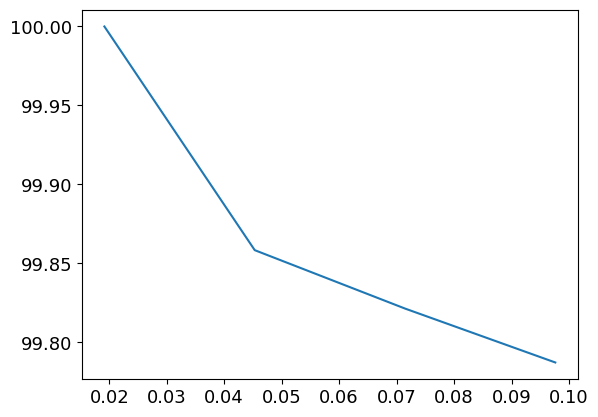

In [73]:
print(All_Scans["1"]['Throughput capacity [kA.h]'][0])
print(All_Scans["2"]["CDend LAM_pe [%]"][0])
plt.plot(
        All_Scans[str(scan)]['Throughput capacity [kA.h]'][0], 
        All_Scans[str(scan)]['CDend SOH [%]'][0])

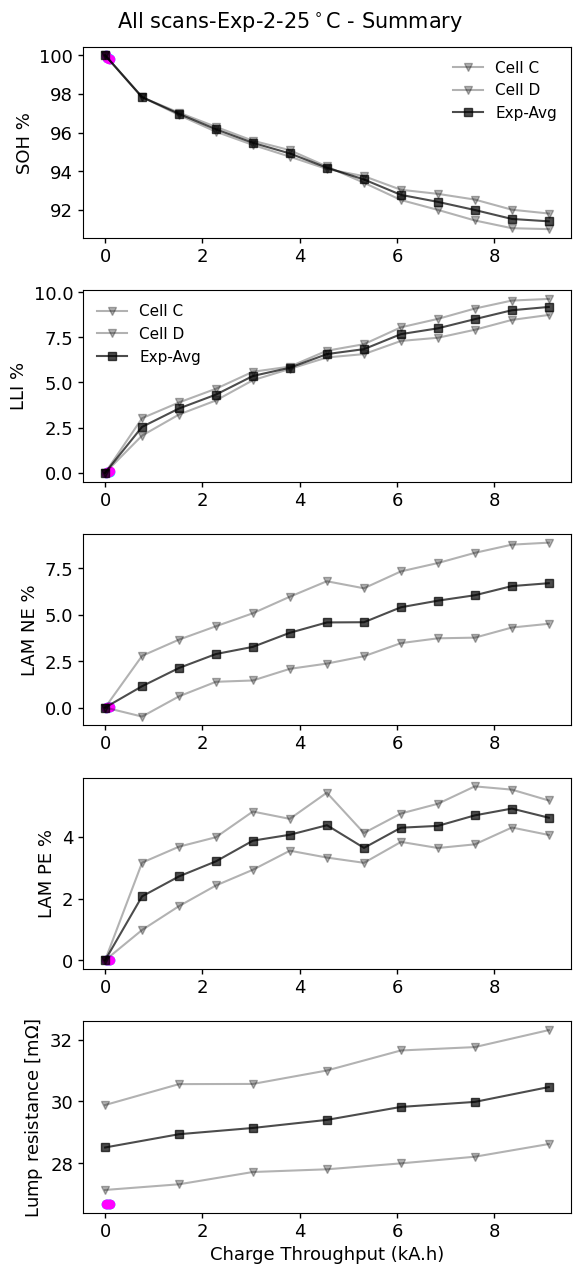

In [87]:
# Reload and plot a summary
Num_subplot = 5;
fig, axs = plt.subplots(Num_subplot,1, figsize=(6,13),tight_layout=True)
cm = mpl.cm.get_cmap("cool", len(index_list))  
for scan in index_list:
    axs[0].plot(
        All_Scans[str(scan)]['Throughput capacity [kA.h]'][0], 
        All_Scans[str(scan)]['CDend SOH [%]'][0],     
        '-o',color=cm(scan-1),  ) # label="Scan=" + str(scan)
    axs[1].plot(
        All_Scans[str(scan)]['Throughput capacity [kA.h]'][0], 
        All_Scans[str(scan)]["CDend LLI [%]"][0],'-o',color=cm(scan-1), )
    axs[2].plot(
        All_Scans[str(scan)]["Throughput capacity [kA.h]"][0], 
        All_Scans[str(scan)]["CDend LAM_ne [%]"][0],'-o',   color=cm(scan-1),   ) 
    axs[3].plot(
        All_Scans[str(scan)]["Throughput capacity [kA.h]"][0], 
        All_Scans[str(scan)]["CDend LAM_pe [%]"][0],    '-o', color=cm(scan-1),  ) 
    axs[4].plot(
        All_Scans[str(scan)]["Throughput capacity [kA.h]"][0], 
        np.array(All_Scans[str(scan)]["Res_0p5C_50SOC"][0]),   '-o', color=cm(scan-1),  ) 
# Plot Charge Throughput (A.h) vs SOH
color_exp     = [0, 0, 0, 0.3]; marker_exp     = "v";
color_exp_Avg = [0, 0, 0, 0.7]; marker_exp_Avg = "s";
# don't change temperature in this case!
Para_dict_i = Para_dict_list[scan-1]
CyclePack,Para_0 = Para_init(Para_dict_i) # initialize the parameter
[Total_Cycles,Cycle_bt_RPT,Update_Cycles,RPT_Cycles,
    Temper_i,Temper_RPT,mesh_list,submesh_strech,model_options] = CyclePack

Exp_temp_i_cell = Temp_Cell_Exp[str(int(Temper_i- 273.15))]
XY_pack = Get_Cell_Mean_1T_1Exp(Exp_Any_AllData,Exp_temp_i_cell) 
Exp_temp_i_cell = Temp_Cell_Exp[str(int(Temper_i- 273.15))]

for cell in Exp_temp_i_cell:
    df = Exp_Any_AllData[cell]["Extract Data"]
    chThr_temp = np.array(df["Charge Throughput (A.h)"])/1e3
    df_DMA = Exp_Any_AllData[cell]["DMA"]["LLI_LAM"]
    axs[0].plot(
        chThr_temp,np.array(df_DMA["SoH"])*100,
        color=color_exp,marker=marker_exp,label=f"Cell {cell}") 
    axs[1].plot(
        chThr_temp,np.array(df_DMA["LLI"])*100,
        color=color_exp,marker=marker_exp,label=f"Cell {cell}")  
    axs[2].plot(
        chThr_temp,np.array(df_DMA["LAM NE_tot"])*100,
        color=color_exp,marker=marker_exp, )
    axs[3].plot(
        chThr_temp,np.array(df_DMA["LAM PE"])*100,
        color=color_exp,marker=marker_exp,)
    # update 230312- plot resistance here
    df = Exp_Any_AllData[cell]["Extract Data"]
    # Exp_1_AllData["A"]["Extract Data"]["0.1s Resistance (Ohms)"]
    index_Res = df[df['0.1s Resistance (Ohms)'].le(10)].index
    axs[4].plot(
        #df["Days of degradation"][index_Res],
        np.array(df["Charge Throughput (A.h)"][index_Res])/1e3,
        np.array(df["0.1s Resistance (Ohms)"][index_Res])*1e3,
        color=color_exp,marker=marker_exp)
# Update 230518: Plot Experiment Average - at 1 expeirment and 1 temperature
[X_1_st,X_5_st,Y_1_st_avg,Y_2_st_avg,
    Y_3_st_avg,Y_4_st_avg,Y_5_st_avg]  = XY_pack
axs[0].plot(
    X_1_st,Y_1_st_avg,color=color_exp_Avg,
    marker=marker_exp_Avg,label=f"Exp-Avg") 
axs[1].plot(
    X_1_st,Y_2_st_avg,color=color_exp_Avg,
    marker=marker_exp_Avg,label=f"Exp-Avg")  
axs[2].plot(
    X_1_st,Y_3_st_avg,color=color_exp_Avg,
    marker=marker_exp_Avg, )
axs[3].plot(
    X_1_st,Y_4_st_avg,
    color=color_exp_Avg,marker=marker_exp_Avg,)
axs[4].plot(
    X_5_st,Y_5_st_avg,
    color=color_exp_Avg,marker=marker_exp_Avg)
axs[0].set_ylabel("SOH %")
axs[1].set_ylabel("LLI %")
axs[2].set_ylabel("LAM NE %")
axs[3].set_ylabel("LAM PE %")
axs[4].set_ylabel(r"Lump resistance [m$\Omega$]")
axs[4].set_xlabel("Charge Throughput (kA.h)")
for i in range(0,Num_subplot):
    labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); 
    [label.set_fontname('DejaVu Sans') for label in labels]
    axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
axs[4].ticklabel_format(style='sci', axis='x', scilimits=(-1e-2,1e-2))
axs[0].legend(prop={'family':'DejaVu Sans','size':fs-2},loc='best',frameon=False)
axs[1].legend(prop={'family':'DejaVu Sans','size':fs-2},loc='best',frameon=False)
fig.suptitle(
    f"All scans-Exp-{index_exp}-{str(int(Temper_i- 273.15))}"
    +r"$^\circ$C - Summary", fontsize=fs+2)
plt.savefig(
    BasicPath + Target+   # "Plots/" +  
    f"0_All scans-Exp-{index_exp}-{str(int(Temper_i- 273.15))}degC Summary.png", dpi=dpi)
# plt.close() 

In [ ]:
print(
    Sol_RPT_all[0][0]["LAM_ne [%]"].entries[-1]
    -Sol_RPT_all[0][0]["LAM_ne [%]"].entries[0])
print(
    Sol_AGE_all[0][0]["LAM_ne [%]"].entries[-1]
    -Sol_AGE_all[0][0]["LAM_ne [%]"].entries[0])

print(
    (Sol_RPT_all[0][0]["LAM_ne [%]"].entries[-1]
    -Sol_RPT_all[0][0]["LAM_ne [%]"].entries[0])/
    (Sol_AGE_all[0][0]["LAM_ne [%]"].entries[-1]
    -Sol_AGE_all[0][0]["LAM_ne [%]"].entries[0]))  

0.013330630794882836
0.005048602931339019
2.6404593461160175


In [ ]:
print(
    Sol_RPT_all[0][0]["Throughput capacity [A.h]"].entries[-1]
    -Sol_RPT_all[0][0]["Throughput capacity [A.h]"].entries[0])
print(
    Sol_AGE_all[0][0]["Throughput capacity [A.h]"].entries[-1]
    -Sol_AGE_all[0][0]["Throughput capacity [A.h]"].entries[0])

print(
    (Sol_RPT_all[0][0]["Throughput capacity [A.h]"].entries[-1]
    -Sol_RPT_all[0][0]["Throughput capacity [A.h]"].entries[0])/
    (Sol_AGE_all[0][0]["Throughput capacity [A.h]"].entries[-1]
    -Sol_AGE_all[0][0]["Throughput capacity [A.h]"].entries[0]))  

19.15337879398967
6.912546717465638
2.7708136489834696


In [90]:
# After finish scans, get summary of the errors of all cases:
fs=17;
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)
Caes_Index = np.arange(1,len(midc_merge_all)+1)
Mpe_tot = []; Mpe_1 = [];Mpe_2 = []; Mpe_3 = [];Mpe_4 = []; Mpe_5 = [];
for i in range(len(midc_merge_all)):
    Mpe_tot.append(midc_merge_all[i]["Error tot %"])
    Mpe_1.append(midc_merge_all[i]["Error SOH %"])
    Mpe_2.append(midc_merge_all[i]["Error LLI %"])
    Mpe_3.append(midc_merge_all[i]["Error LAM NE %"])
    Mpe_4.append(midc_merge_all[i]["Error LAM PE %"])
    Mpe_5.append(midc_merge_all[i]["Error Res %"])
Mpe_All = [Mpe_tot,Mpe_1,Mpe_2,Mpe_3,Mpe_4,Mpe_5]
Str_All = [
    "Error tot %","Error SOH %","Error LLI %",
    "Error LAM NE %","Error LAM PE %","Error Res %"]
fig, axs = plt.subplots(2,3, figsize=(12,8),tight_layout=True)
for i in range(6):
    if i<=2: # 0,1,2
        m=0; n = i
    else:   # 3,4,5 
        m=1; n = i-3
    axs[m,n].plot( Caes_Index,  Mpe_All[i], '-o',  )
    axs[m,n].set_ylabel(Str_All[i])
    axs[1,n].set_xlabel("Case No.")
    fig.suptitle(
        f"Error Summary of all cases in this round", 
        fontsize=fs+1)
plt.savefig(
    BasicPath +  Target+
    f"test_0!_-{index_exp} - Error Summary of all cases.png", dpi=600)
plt.savefig(
    BasicPath + Target+
    f"test_0!_Exp-{index_exp} - Error Summary of all cases.svg")
plt.close()


In [89]:

Index_List_succeed = index_list
for index_i in Index_List_succeed:
    #print(index_i)
    try:
        old_book = str(index_i) + '_' + book_name_xlsx
        #print(old_book)
        #open excel:
        data_old = openpyxl.load_workbook(
            BasicPath + Target+ "Excel/" + old_book)   
        data_tar = openpyxl.load_workbook(
            BasicPath + Target + book_name_xlsx) 

        table_old = data_old[str(index_i)]
        nrows_old = table_old.max_row  # 获得行数
        ncolumns_old = table_old.max_column  # 获得列数

        table_tar = data_tar[sheet_name_xlsx]
        nrows_tar = index_i # Mark!!! Most important changes!
        ncolumns_old = table_old.max_column  # 获得列数
        list_old = [];
        #print(nrows_old,nrows_tar)
        for i in range(1,nrows_old+1):
            for j in range(1,ncolumns_old+1):
                list_old.append(table_old.cell(row=i,column=j).value)
        
        list_old = [list_old,]
        for i in range(1, len(list_old)+1):
                for j in range(1, len(list_old[i-1])+1):
                    #print(i,j,list_old[i-1][j-1]    )
                    table_tar.cell(nrows_tar+i, j).value = list_old[i-1][j-1]     
        data_tar.save(BasicPath + Target + book_name_xlsx) 
        data_tar.close()
    except:
        print(f"Something goes wrong for Scan {index_i}!")
    else:
        print(f"Successfuly write results for Scan {index_i}!") 


Successfuly write results for Scan 1!
Successfuly write results for Scan 2!
